# Portfolio Attributes

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
from   scipy.stats import ttest_1samp

import matplotlib.pyplot as plt
from   matplotlib.ticker import FuncFormatter

In [2]:
import sys
sys.path.append(r"C:\Users\Diego\Desktop\app_prod\research\CommodityForwardInflation\root\src")
from PortfolioAttributes import PortfolioAttributes

In [3]:
def get_longer() -> pd.DataFrame:

    df_port = (PortfolioAttributes()._prep_rtn().rename(columns = {
        "port"    : "variable", 
        "port_rtn": "val"}).
        assign(year = lambda x: x.date.dt.year).
        query("year >= 2012"))
    
    df_out = (pd.concat([
        PortfolioAttributes()._prep_benchmark().rename(columns = {"benchmark": "variable", "benchmark_rtn": "val"}),
        df_port]))
    
    return df_out

df_longer = get_longer()

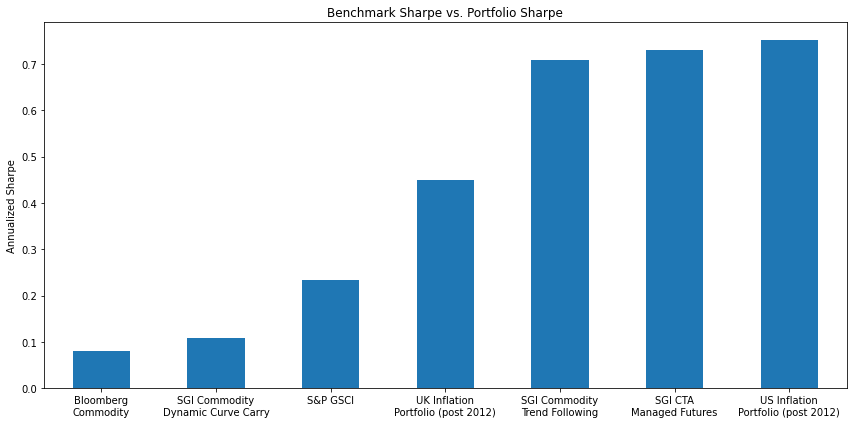

In [4]:
def plot_sharpe(df_longer: pd.DataFrame) -> plt.Figure: 
    
    replacer = {
        "BCOM"    : "Bloomberg\nCommodity",
        "SGIXTFCY": "SGI Commodity\nTrend Following",
        "SGMDDBMF": "SGI CTA\nManaged Futures",
        "SPGSCI"  : "S&P GSCI",
        "SGCOCOC2": "SGI Commodity\nDynamic Curve Carry",
        "FWISBP55": "UK Inflation\nPortfolio (post 2012)",
        "FWISUS55": "US Inflation\nPortfolio (post 2012)"}

    (df_longer.drop(
        columns = ["date"]).
        groupby("variable").
        agg(["mean", "std"])
        ["val"].
        rename(columns = {
            "mean": "mean_rtn", 
            "std" : "std_rtn"}).
        assign(sharpe = lambda x: x.mean_rtn / x.std_rtn * np.sqrt(252)).
        reset_index().
        sort_values("sharpe").
        replace(replacer).
        set_index("variable")
        [["sharpe"]].
        plot(
            kind    = "bar",
            figsize = (12,6),
            legend  = False,
            ylabel  = "Annualized Sharpe",
            rot     = 0,
            title   = "Benchmark Sharpe vs. Portfolio Sharpe",
            xlabel  = ""))
    
    plt.tight_layout()
    
plot_sharpe(df_longer)

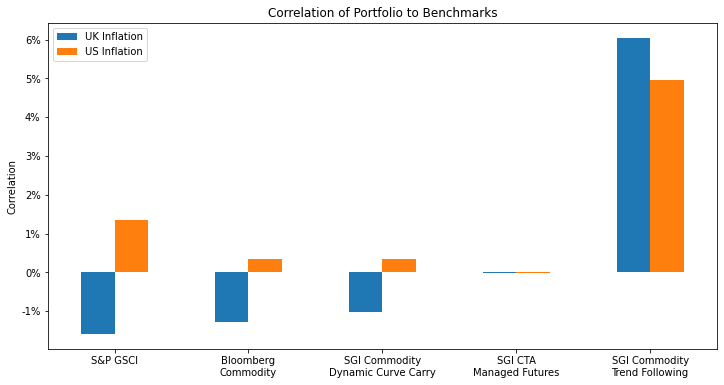

In [5]:
def plot_correlation(df_longer: pd.DataFrame) -> plt.Figure: 
    
    fig, axes = plt.subplots(figsize = (12,6))

    ports = ["FWISBP55", "FWISUS55"]
    replacer = {
        "BCOM"    : "Bloomberg\nCommodity",
        "SGIXTFCY": "SGI Commodity\nTrend Following",
        "SGMDDBMF": "SGI CTA\nManaged Futures",
        "SPGSCI"  : "S&P GSCI",
        "SGCOCOC2": "SGI Commodity\nDynamic Curve Carry"}

    col_renamer = {
        "FWISBP55": "UK Inflation",
        "FWISUS55": "US Inflation"}

    (df_longer.pivot(
        index = "date", columns = "variable", values = "val").
        corr().
        reset_index().
        query("variable != @ports").
        rename(columns = replacer)
        [ports + ["variable"]].
        rename(columns = {"variable": "tmp"}).
        melt(id_vars = "tmp").
        replace(replacer).
        rename(columns = {"variable": ""}).
        pivot(index = "tmp", columns = "", values = "value").
        sort_values("FWISBP55").
        rename(columns = col_renamer).
        plot(
            ax      = axes,
            kind    = "bar",
            rot     = 0, 
            figsize = (12,6),
            xlabel  = "",
            title   = "Correlation of Portfolio to Benchmarks",
            ylabel  = "Correlation"))

    axes.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y * 100:.0f}%'))
    
plot_correlation(df_longer)

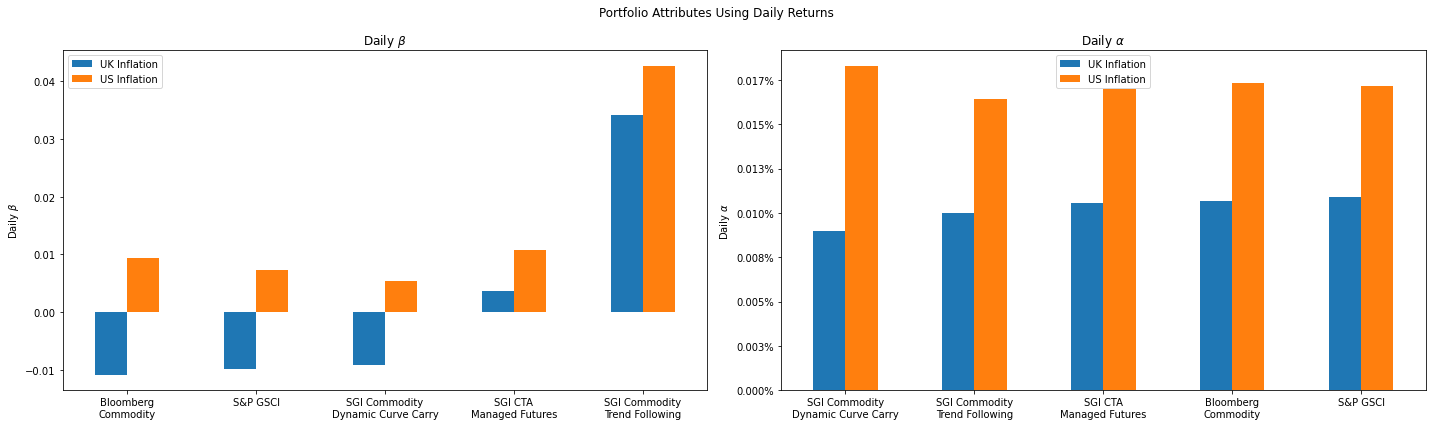

In [6]:
def plot_performance_attributes() -> plt.Figure: 
    
    df_tmp    = PortfolioAttributes().OLSPerformance().rename(columns = {"index": "param"})
    params    = df_tmp.param.drop_duplicates().sort_values().to_list()
    fig, axes = plt.subplots(ncols = len(params), figsize = (20,6))

    col_renamer = {
        "FWISBP55": "UK Inflation",
        "FWISUS55": "US Inflation"}

    replacer = {
        "BCOM"    : "Bloomberg\nCommodity",
        "SGIXTFCY": "SGI Commodity\nTrend Following",
        "SGMDDBMF": "SGI CTA\nManaged Futures",
        "SPGSCI"  : "S&P GSCI",
        "SGCOCOC2": "SGI Commodity\nDynamic Curve Carry"}

    param_namer = {
        "benchmark_rtn": r"$\beta$",
        "const"        : r"$\alpha$"}

    for param, ax in zip(params, axes.flatten()):

        (df_tmp.query(
            "param == @param").
            rename(columns = {"port": ""}).
            replace(replacer).
            pivot(index = "benchmark", columns = "", values = "param_val").
            sort_values("FWISBP55").
            rename(columns = col_renamer).
            plot(
                kind   = "bar",
                ax     = ax,
                rot    = 0,
                xlabel = "",
                ylabel = "Daily " + param_namer[param],
                title  = "Daily " + param_namer[param]))

        if param == "const": ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y * 100:.3f}%'))

    fig.suptitle("Portfolio Attributes Using Daily Returns")
    plt.tight_layout()
    
plot_performance_attributes() 

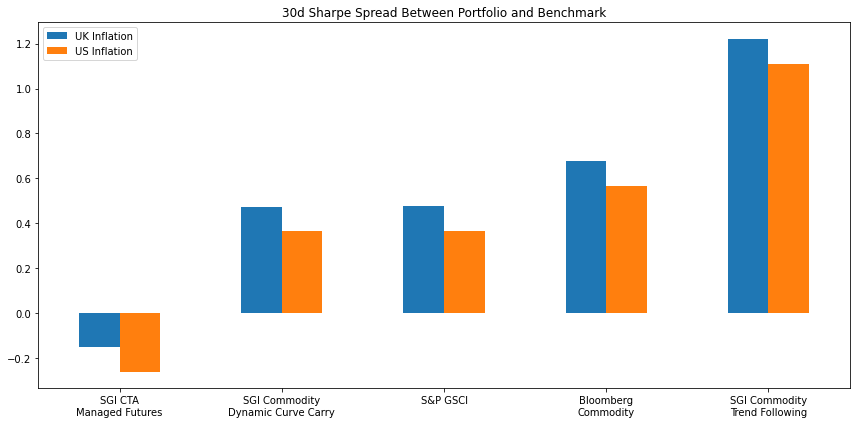

In [7]:
def plot_sharpe_spread(df_longer: pd.DataFrame) -> plt.Figure: 
    
    col_renamer = {
        "FWISBP55": "UK Inflation",
        "FWISUS55": "US Inflation"}

    replacer = {
        "BCOM"    : "Bloomberg\nCommodity",
        "SGIXTFCY": "SGI Commodity\nTrend Following",
        "SGMDDBMF": "SGI CTA\nManaged Futures",
        "SPGSCI"  : "S&P GSCI",
        "SGCOCOC2": "SGI Commodity\nDynamic Curve Carry"}

    (df_longer.pivot(
        index = "date", columns = "variable", values = "val").
        apply(lambda x: x.rolling(window = 30).mean() / x.rolling(window = 30).std() * np.sqrt(252)).
        reset_index().
        melt(
            id_vars    = ["date", "FWISUS55", "FWISBP55"],
            var_name   = "benchmark",
            value_name = "benchmark_sharpe").
        dropna().
        melt(
            id_vars    = ["date", "benchmark", "benchmark_sharpe"],
            var_name   = "port",
            value_name = "port_sharpe").
        assign(sharpe_spread = lambda x: x.port_sharpe - x.benchmark_sharpe)
        [["benchmark", "port", "sharpe_spread"]].
        groupby(["benchmark", "port"]).
        agg("mean").
        reset_index().
        replace(replacer).
        rename(columns = {"port": ""}).
        pivot(index = "benchmark", columns = "", values = "sharpe_spread").
        sort_values("FWISUS55").
        rename(columns = col_renamer).
        plot(
            kind    = "bar",
            rot     = 0,
            figsize = (12,6),
            xlabel  = "",
            title   = "30d Sharpe Spread Between Portfolio and Benchmark"))
    
    plt.tight_layout()
    
plot_sharpe_spread(df_longer)

In [8]:
df_avg = (PortfolioAttributes().RollingOLSPerformance().melt(
    id_vars = ["date", "port", "benchmark"]).
    dropna().
    drop(columns = ["date"]).
    groupby(["port", "benchmark", "variable"]).
    agg("mean").
    reset_index())

In [9]:
def _get_ttest(df: pd.DataFrame) -> pd.DataFrame:
    
    t_stat, p_value = (ttest_1samp(a = df.value, popmean = 0))
    df_out          = (pd.DataFrame({
        "tstat" : [t_stat],
        "pvalue": [p_value]}))
    
    return df_out

def plot_ttest() -> None:

    replacer = {
        "BCOM"    : r"Bloomberg Commodity",
        "SGIXTFCY": r"SGI Commodity Trend Following",
        "SGMDDBMF": r"SGI CTA Managed Futures",
        "SPGSCI"  : r"S&P GSCI",
        "SGCOCOC2": r"SGI Commodity Dynamic Curve Carry",
        "FWISBP55": r"UK Inflation",
        "FWISUS55": r"US Inflation"}

    variable_replacer = {
        "benchmark_rtn": r"Beta",
        "const"        : r"Alpha"}

    (PortfolioAttributes().RollingOLSPerformance().melt(
        id_vars = ["date", "port", "benchmark"]).
        dropna().
        drop(columns = ["date"]).
        groupby(["port", "benchmark", "variable"]).
        apply(_get_ttest).
        reset_index().
        drop(columns = ["level_3"]).
        rename(columns = {
            "port"     : "Portfolio",
            "benchmark": "Benchmark",
            "variable" : "Variable",
            "tstat"    : "T-Statistic",
            "pvalue"   : "P-value"}).
        replace(replacer).
        replace(variable_replacer).
        to_html())
    
plot_ttest()

'<table border="1" class="dataframe">  <thead>    <tr style="text-align: right;">      <th></th>      <th>Portfolio</th>      <th>Benchmark</th>      <th>Variable</th>      <th>T-Statistic</th>      <th>P-value</th>    </tr>  </thead>  <tbody>    <tr>      <th>0</th>      <td>UK Inflation</td>      <td>Bloomberg Commodity</td>      <td>Beta</td>      <td>1.647289</td>      <td>9.956003e-02</td>    </tr>    <tr>      <th>1</th>      <td>UK Inflation</td>      <td>Bloomberg Commodity</td>      <td>Alpha</td>      <td>5.379344</td>      <td>7.808002e-08</td>    </tr>    <tr>      <th>2</th>      <td>UK Inflation</td>      <td>SGI Commodity Dynamic Curve Carry</td>      <td>Beta</td>      <td>2.697559</td>      <td>7.011420e-03</td>    </tr>    <tr>      <th>3</th>      <td>UK Inflation</td>      <td>SGI Commodity Dynamic Curve Carry</td>      <td>Alpha</td>      <td>2.945425</td>      <td>3.241890e-03</td>    </tr>    <tr>      <th>4</th>      <td>UK Inflation</td>      <td>SGI Commodity Trend Following</td>      <td>Beta</td>      <td>4.739087</td>      <td>2.204906e-06</td>    </tr>    <tr>      <th>5</th>      <td>UK Inflation</td>      <td>SGI Commodity Trend Following</td>      <td>Alpha</td>      <td>5.330190</td>      <td>1.023148e-07</td>    </tr>    <tr>      <th>6</th>      <td>UK Inflation</td>      <td>SGI CTA Managed Futures</td>      <td>Beta</td>      <td>-2.012961</td>      <td>4.417092e-02</td>    </tr>    <tr>      <th>7</th>      <td>UK Inflation</td>      <td>SGI CTA Managed Futures</td>      <td>Alpha</td>      <td>6.871323</td>      <td>7.119371e-12</td>    </tr>    <tr>      <th>8</th>      <td>UK Inflation</td>      <td>S&amp;P GSCI</td>      <td>Beta</td>      <td>2.085813</td>      <td>3.704488e-02</td>    </tr>    <tr>      <th>9</th>      <td>UK Inflation</td>      <td>S&amp;P GSCI</td>      <td>Alpha</td>      <td>3.381934</td>      <td>7.251633e-04</td>    </tr>    <tr>      <th>10</th>      <td>US Inflation</td>      <td>Bloomberg Commodity</td>      <td>Beta</td>      <td>1.180399</td>      <td>2.378978e-01</td>    </tr>    <tr>      <th>11</th>      <td>US Inflation</td>      <td>Bloomberg Commodity</td>      <td>Alpha</td>      <td>9.365270</td>      <td>1.118485e-20</td>    </tr>    <tr>      <th>12</th>      <td>US Inflation</td>      <td>SGI Commodity Dynamic Curve Carry</td>      <td>Beta</td>      <td>-0.062936</td>      <td>9.498201e-01</td>    </tr>    <tr>      <th>13</th>      <td>US Inflation</td>      <td>SGI Commodity Dynamic Curve Carry</td>      <td>Alpha</td>      <td>9.032690</td>      <td>2.449830e-19</td>    </tr>    <tr>      <th>14</th>      <td>US Inflation</td>      <td>SGI Commodity Trend Following</td>      <td>Beta</td>      <td>4.256725</td>      <td>2.112374e-05</td>    </tr>    <tr>      <th>15</th>      <td>US Inflation</td>      <td>SGI Commodity Trend Following</td>      <td>Alpha</td>      <td>9.594996</td>      <td>1.286395e-21</td>    </tr>    <tr>      <th>16</th>      <td>US Inflation</td>      <td>SGI CTA Managed Futures</td>      <td>Beta</td>      <td>1.819228</td>      <td>6.893640e-02</td>    </tr>    <tr>      <th>17</th>      <td>US Inflation</td>      <td>SGI CTA Managed Futures</td>      <td>Alpha</td>      <td>11.662849</td>      <td>4.955312e-31</td>    </tr>    <tr>      <th>18</th>      <td>US Inflation</td>      <td>S&amp;P GSCI</td>      <td>Beta</td>      <td>5.255395</td>      <td>1.538368e-07</td>    </tr>    <tr>      <th>19</th>      <td>US Inflation</td>      <td>S&amp;P GSCI</td>      <td>Alpha</td>      <td>9.892604</td>      <td>7.255676e-23</td>    </tr>  </tbody></table>'